# Numerical Methods Week 4: Finite Difference Method for PDEs
### written by Ernesto Barraza-Valdez, Shailaja Humane, Alyssa Hayes and the CRANE team

Reminder: [Code of conduct](https://docs.google.com/presentation/d/1UiBbQLGCZ_8VTTufJGitjnfz2Lj12TzAPuvHLvRLMhk/edit?usp=sharing)


In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as plticker
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
import random
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider

%matplotlib inline

#**GOALS**



*   Learn how to discretize ODEs and PDEs using the Finite Difference Method
*   Learn how to solve Matrix Systems using Gauss-Seidel and Over-Relaxation Methods
*  Apply above to solve the heat equation
*  Use the finite difference equations to solve for the Electric field in an electrostatics problem



##Solving PDEs

Most times, Partial Differential Equations (PDE) are impossible to solve analytically (by hand). As computers get faster, large and impossible tasks become possible.

Many PDE and Ordinary Differential Equation (ODE) solvers are becoming automated and easy to use. This is great, however, in order to become a researcher you should understand the basic algorithms behind these solvers. This will allow you to edit, adapt, or make your own solvers for more specific problems.

Enough chit-chat. Let's begin.

##Derivation of Finite Difference Method

We will begin our journey with the finite difference method and solve a single 1D ODE. We will then work our way up by adding dimensions and solving PDEs.

The finite difference method a rearrangment of the [Taylor Expansion](https://en.wikipedia.org/wiki/Taylor_series) [video explanation](https://www.google.com/url?q=https://youtu.be/3d6DsjIBzJ4&sa=D&source=editors&ust=1649736022816954&usg=AOvVaw3oJ1FWe1_xf_DLZxtEe2ts)

But first we must understand that computers are discrete systems. Computers have physical memory that can only hold values at certain intervals. This means they cannot know or hold the infinite amount of values that a *continuous* or real life system offer.

So say we're solving for the temperature across an aluminum block. There are an infinite amount of places on the block where you could calculate the temperature, this is a continous system. However, a computer cannot do this so we have to break up our block into small discrete intervals (or cells) so as to make up a grid where the temperature will be found. The grid points where the temperature is solved are separated by a small distance which we will call $\Delta x$

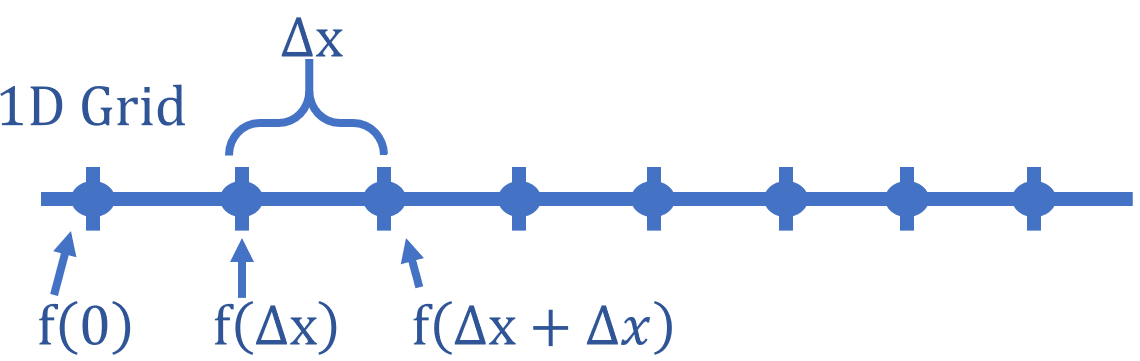


Now back to the taylor expansion (series). We can expand any function we're looking for (say temperature) and expand it about this separation distance $\Delta x$.

$$
\begin{align}
f(x+\Delta x) = f(x) + \frac{\Delta x}{1!}\frac{d f}{d x} + \frac{\Delta x^2}{2!}\frac{d^2 f}{d x^2} + \cdot\cdot\cdot
\tag{1}
\end{align}
$$

We want to find the derivative in terms of this small $\Delta x$ so we shuffle around some algebra and get:

$$
\begin{align}
\frac{d f}{d x}  = \frac{ f(x+\Delta x) -  f(x)}{\Delta x} - \frac{\Delta x}{2}\frac{d^2 f}{d x^2} + \cdot\cdot\cdot
\tag{2}
\end{align}
$$

So we have somewhat *discretized* the first derivative. One thing we must notice is that the second derivative is still there and not discritized. For now we will just call this an error and the error is proportional to $\Delta x$. Mathematicians and computer scientists use the big O notation to describe errors: $O(\Delta x)$

Discretizing many derivatives like this means you begin adding up many $O(\Delta x)$ errors. Even if your $\Delta x$ is small (small grid spacing), if you loop over an algorithm 1000's of times the error begins to add up and eat at the accuracy of your results.

So how do we improve? By using another taylor expansion except in the $-\Delta x$ direction.

$$
\begin{align}
f(x-\Delta x) = f(x) - \frac{\Delta x}{1!}\frac{d f}{d x} + \frac{\Delta x^2}{2!}\frac{d^2 f}{d x^2} + \cdot\cdot\cdot
\tag{3}
\end{align}
$$

$$
\begin{align}
\frac{d f}{d x}  = -\frac{ f(x-\Delta x) -  f(x)}{\Delta x} + \frac{\Delta x}{2}\frac{d^2 f}{d x^2} + \cdot\cdot\cdot
\tag{4}
\end{align}
$$

&nbsp;

Adding (2) and (4) together and dividing by 2 we get rid of our 2nd order differential :

&nbsp;
$$
\begin{align}
\frac{d f}{d x}  = \frac{ f(x+\Delta x) -  f(x-\Delta x)}{2\Delta x} + \frac{\Delta x^2}{3!}\frac{d^3 f}{d x^3} + \cdot\cdot\cdot
\tag{5}
\end{align}
$$

&nbsp;

We have now discretized the first derivative at a single point by using the surrounding points and "averaging". We are left with an error of the 3rd order differential multiplied by $\Delta x^2$ or an error of $O(\Delta x^2)$ which is much better than our first attempt. Remember, an error of $\Delta x =0.1$ is larger than an error of $\Delta x^2 =0.1^2 = 0.01$



Similarly, for the second derivative:

$$
\begin{align}
\frac{d^2 f}{d x^2}  = \frac{ f(x-\Delta x)- 2 f(x) + f(x+\Delta x)}{\Delta x^2} + O(\Delta x^2)
\tag{6}
\end{align}
$$

The above two are known as the **Central Difference Equations**.

For most purposes, these are sufficient and easy to code and do not take much computational resources. Of course there are more accurate finite difference discretizations but for our purposes these are good enough.

##Applying the Finite Central Difference Equations

So equations (5) and (6) are fairly simple and easy to use. Well, easy to use for small systems (small grids).

Let's take a look at a quick example.

**Heat Equation in 1D**

$$
\begin{align}
\alpha ^2 \frac{d^2 T}{d x^2}  = 0
\tag{7}
\end{align}
$$

And we will set it up in 1D grid of just 4 points.

We rename the points according to their relative position. For example:

$T_0 = T(x = 0)$

$T_1 = T(x=\Delta x)$

$T_2 = T(x=2\Delta x)$

etc...

Before we continue on, we will say that $T_0$ and $T_3$ are known. These known values are the boundary conditions you need to solve any differential equation system.

Now, we apply the central finite difference equation to each unknown point $T_1$ and $T_2$.

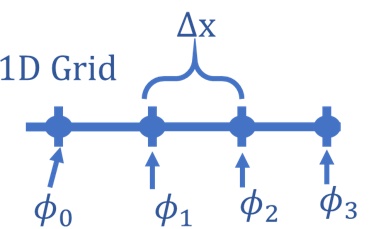

$$
\begin{align}
\frac{d^2 T_1}{d x^2}  = \frac{ T_0- 2 T_1 + T_2}{\Delta x^2} + O(\Delta x^2)  \approx 0
\tag{8}
\end{align}
$$

$$
\begin{align}
\frac{d^2 T_2}{d x^2}  = \frac{ T_1- 2 T_2 + T_3}{\Delta x^2} + O(\Delta x^2) \approx 0
\end{align}
$$



WE have skipped equations of $T_0$ and $T_3$ because those are known values. More generally (for arbitrary amount of points on a grid):

$$
\begin{align}
\frac{d^2 T_i}{d x^2}  = \frac{ T_{i-1}- 2 T_{i} + T_{i+1}}{\Delta x^2} + O(\Delta x^2)\approx 0
\tag{9}
\end{align}
$$

##General Central Finite Difference for Heat Equation
Thus, for a point ($i$) inside the specified (initial) boundary conditions, the potential $T_i$ can be calculated as:


$$
\begin{align}
T_{i} = \frac{1}{2}T_{i-1} + \frac{1}{2}T_{i+1}
\tag{10}
\end{align}
$$


Now we solve for $T_1$ and $T_2$ using (8) given $T_0$ and $T_3$. We drop the errors in our central difference approximations.

Using (8) we solve for $T_1$:

$$
\begin{align}
T_1 \approx \frac{T_0+T_2 }{2}  
\tag{11}
\end{align}
$$

$$
\begin{align}
T_2 \approx \frac{1}{2}  T_1 + \frac{1}{2}T_3
\tag{12}
\end{align}
$$

We can substitute (12) into (11) since $T_0$ and $T_3$ are known:


$$
\begin{align}
T_1 \approx \frac{1}{2}  T_0 + \frac{1}{2}(\frac{1}{2}  T_1 + \frac{1}{2}T_3 )
\end{align}
$$

And can now solve for $T_1$:

$$
\begin{align}
T_1 \approx \frac{2}{3}  T_3 + \frac{1}{3}T_0
\end{align}
$$

and

$$
\begin{align}
T_2 \approx \frac{2}{3}  T_0 + \frac{1}{3}T_3
\end{align}
$$

We have now solved this small system completely!!!! (*with some errors)

#**Ok but that didn't use computers and code at all...**

Indeed... However, imagine doing this substitution method for hundreds or thousands of points. This is why you need computers.

Just to go a bit further, this substitution method cannot be programmed easily into an alogorithm. We derived each grid point's potential by hand. Again with hundreds or thousands of points it is not viable. So we need better methods that are fast yet accurate enough.

So now let's try with arbitrarily large amount of points. We can write the finite difference equations for the electric potential as follows:

$$
\begin{align}
T_0 = \text{Given Boundary Value}
\end{align}
$$

$$
\begin{align}
 \left(\frac{1}{\Delta x^2}\right)(T_0- 2 T_1 + T_2)  = 0
\end{align}
$$

$$
\begin{align}
 \left(\frac{1}{\Delta x^2}\right)(T_1- 2 T_2 + T_3)  = 0
\end{align}
$$

$$
\begin{align}
 \left(\frac{1}{\Delta x^2}\right)(T_2- 2 T_3 + T_4)  = 0
\end{align}
$$

$$
\begin{align}
\cdot
\end{align}
$$
$$
\begin{align}
\cdot
\end{align}
$$
$$
\begin{align}
\cdot
\end{align}
$$

$$
\begin{align}
T_{N-1} = \text{Given Boundary Value}
\end{align}
$$

**We can view this as a matrix system**

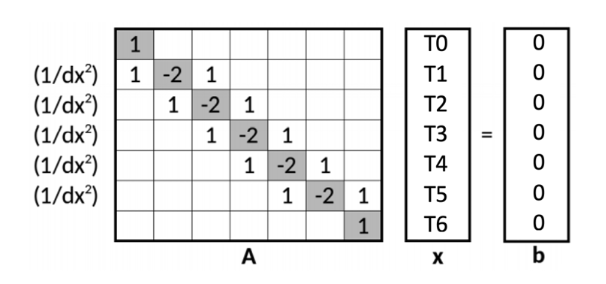

We can solve this using matrix algebra by finidng the inverse matrix of **A**. There are many algorithms that are fast but computationally expensive when it comes to solving this matrix problem.

For the purposes of learning algorithms and physics, we will side step this and use other well known algorithms to solve this problem and just step through each point $T_i$ and solve equation (10).

#**Gauss-Seidel Method**

For our choice of solver, we will use the [Gauss-Seidel Method](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method) (GS).

Note that the wikipedia says:
"Though it can be applied to any matrix with non-zero elements on the diagonals, convergence is only guaranteed if the matrix is either strictly diagonally dominant, or symmetric and positive definite."

We can see from our above picture of our matrix formulation that our finite difference matrix formulation does indeed satisfy the diagonally dominant.

We won't derive it but as shown in the wiki, it's clearly meant to solve these type of matrix problems.

The general idea is that you enter in a guess at the values for the solution and the computer loops through many iterations (this is a separate loop from the Finite Difference loop) until it converges close the the actual solution. The GS algorithm can be described using using equation (10) in the following way:

$$
\begin{align}
T_i^{k} = \left(T_{i-1}^{k} + T_{i+1}^{k-1} \right)/2
\tag{13}
\end{align}
$$

Where the superscript $k$ is the number of the GS iteration while the lower-script $i$ is the position on the finite difference grid. For example, your first input is the guess for $T_i$ and the GS iteration $k=0$. Then the GS method will guess the next best answer for $T_i$ and call that $k=1$. It will continue to produce better guesses until told to stop or reaching a threshold value of convergence given by the user.



##Intuition:
This method starts with a guess of the solution, and loops over the discritized equations to improve that guess with every Gauss Seidel iteration.

##Pseudocode:
The corresponding pseudocode for the **Finite Difference Method with Gauss-Seidel Iterative Solver** looks like the following:

```
# Create array to hold solutions
# Apply boundary conditions


# For loop for GS iteration
    # For loop for parsing through T(x)
        # Update T(x) using Equation 13
```

##Project 1: Write your own FD GS algorithm to solve for the temperature along a metal rod

Let's go ahead and program this up and solve our very first problem!
We will try solving the heat distribution along a rod that has a hot end and a cold end.



The one thing we need to take special note of is that our $b$ vector which contains our charge density constants is zero. This makes our code even easier.

In [ ]:
def GS_Temperature_Solver(T_0, T_N, numpoints, GSiter):
  """ Returns: 1D matrix of solutions for temperature across a metal rod

    Solved with Gauss-Seidel Method

    Parameter T_0: first boundary condition
    Parameter T_N: second boundary condition
    Parameter numpoints: number of grid points
    Parameter GSiter: number of Gauss-Seidel iterations
  """

  # create matrix of zeros to hold solutions for Temperature (T)
  T = np.zeros(numpoints)
  # put boundary conditions into Temperature (T)
  # remember indices in python start from zero
  T[0] = T_0 # left side of the rod
  T[numpoints-1] = T_N # right side of the rod
  # this array T is now our first "guess" of the solution!

  #TODO: implement Gauss-Seidel Method to solve for Temperature (T)
  for k in range(GSiter):
    for i in range(1, numpoints-1):
        T[i] = 1/2 * (T[i-1] + T[i+1])


  return T

In [ ]:
# boundary conditions
T_left = 20 #temp at left end of rod (T0)
T_right = 40 #temp at right end of rod (TN)

# get temperature by calling your function
temperature = GS_Temperature_Solver(T_left, T_right, 100, 10)

#this is over 10 cm
x = np.linspace(0,10,100)
plt.plot(x,temperature)
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (T)')
plt.title('Gauss-Seidal Method For temperature Across Rod')
plt.show()

##Successive Over Relaxation for Improved Solving Performance

We can speed up our algorithm by adding in **Successive Over-Relaxation**. The scheme uses the old and new approximation to predict the next iteration's solution.

Given our discretized differential equation, we approximated $T$ using $T^{\text{approx}}$:

$$
\begin{align}\tag{13a}
T^{\text{approx}} &= \frac{1}{2}T_{i-1} + \frac{1}{2}T_{i+1}
\end{align}
$$

Now, we can use this discretized approximation $T^{\text{approx}}$ and the previous solution (which starts with a guess) $T^{\text{old}}$ to construct a new solution:
$$
\begin{align}\tag{13b}
T^{\text{new}} &= T^{\text{old}} +w(T^{\text{approx}} - T^{\text{old}})
\end{align}
$$

Where $w$ is the fitting parameter. $w > 1$ is called **over relaxation** while $w<1$ is called **under relaxation**.

$w$ must be found through trial and error but it's customary to start with $w=1.4$

Again this can be written for each iteration k of the over-relaxation loop:

$$
\begin{align}\tag{13c}
T^{k} &= T^{k-1} +w(T^{\text{approx}} - T^{k-1})
\end{align}
$$

Below is the psuedocode:

```
# Apply boundary conditions

# For loop for GS iteration
    # For loop for stepping through T(x)
        # Use Equation 13a to approximate T as before, getting T_approx
        # Calculate T_new using Equations 13b or 13c using T_approx and the fitting parameter
```

##Project 2: Modify your FD GS code for temperature along a metal rod and incorporate the Over Relaxation method

Let's use our previous GS code and improve upon it:

In [ ]:
def OverRelaxation(T_0, T_N, N, iter, w):
  """ Returns: 1D matrix of solutions for temperature across a metal rod

    Solved with Over-Relaxation Method

    Parameter T_0: first boundary condition
    Parameter T_N: second boundary condition
    Parameter N: number of grid points
    Parameter iter: number of over-relaxation iterations
    Parameter w: fitting parameter
  """

  #TODO: set up T array filled with zeros
  #zeros is our initial guess
  T = np.zeros(N)

  #put boundary conditions into Temperature (T)
  T[0] = T_0
  T[N-1] = T_N #remember indices in python start from zero

  #TODO: implement over-relaxation method to solve for Temperature (T)
  #Rememeber, you'll need two for loops
  for k in range(iter):
    for i in range(1, N-1):
        T1 = 1/2 * (T[i-1] + T[i+1])
        T[i] = T[i] - T[i] * w + T1 * w

  return T

Plot

In [ ]:
# boundary conditions
T_left = 80 #temp at left end of rod (T0)
T_right = 0 #temp at right end of rod (TN)

# get temperature through OverRelaxation
w = 1.7
temp1 = OverRelaxation(T_left, T_right, 100, 10, w)

#try 100 iter
temp2 = OverRelaxation(T_left, T_right,  100, 100, w)

# TODO: now plot for 500 iter, and compare to how GS did
temp3 = OverRelaxation(T_left, T_right, 100, 500, w)

#this is over 10 cm
x= np.linspace(0,10,100)
plt.plot(x,temp1, label='k=10', linestyle = "dashed")
plt.plot(x,temp2, label='k=100')
plt.plot(x,temp2, label='k=500', linestyle = "dashed")
plt.legend()
plt.show()

As you can see, this is a massive improvement over the regular GS method.

But the question still remains, how do we know how many GS iterations we need to converge to a "good enough" result?

It's really hard to know. However, we can do a convergence check, say every 50 iterations to see how much our solution has changed. To get a proper estimate of the convergence we need to calculate the **Residue** (error) of our system ($R_i^k$).

$$
\begin{align}
AT_i^k = b_i^k + R_i^k \rightarrow R_i^k = AT_i^k - b_i^k
\end{align}
$$

$$
\begin{align}
\rightarrow R_i^k = A T_i^k - b_i^k
\end{align}
$$
Where $b_i = 0$

As $T^k$ approaches the true solution, $R^k$ becomes smaller and smaller. So we could check this every now and then but it is too computationally expensive to check every iteration. To get a better idea of how close to the true solution we are, scientists usually normalize $R$:


$$
\begin{align}
L2 = ||R^k|| = \sqrt{\sum^n_{i=0}(R_i^k)^2/n}
\end{align}
$$

Where $n$ is the total number of grid points.

The usual number to check is to make sure $R$ gets below $10^{-6}$

Below is the psuedocode:

```
# Set up array for potential filled with zeros

# Apply boundary conditions

# For loop for GS iteration
    # For loop for stepping through T(x)
        # Use Equation 13a to approximate T as before, getting T_approx
        # Calculate T_new using Equations 13b or 13c using T_approx and the fitting parameter

# Check for convergence every 50 iterations
    # Initialize summation as 0
    # Loop through temperature (T)
        # Calculate the residue as above
        # Update the summation by adding the next (R_i)**2

    # Calculate L2 as above
    # Check for Convergence if L2 is less than the given residue limit

# Return T
```

In [ ]:
def OverRelaxation_Residues(T_0, T_N, numpoints, dx, GSiter, w, res_limit):
    #set up T array filled with zeros
    #zeros is our initial guess
    T = np.zeros(numpoints)

    #put boundary conditions into Temperature (T)
    T[0] = T_0
    T[numpoints-1] = T_N #remember indices in python start from zero

    for k in range(GSiter):
        for i in range(1, numpoints-1):
            T1 = 1/2 * (T[i-1] + T[i+1])
            T[i] = T[i-1] + w * (T1 - T[i-1])

            #Residue
            if(k%50 == 0):
                sum = 0
                for i in range(1,numpoints-1):
                    R = -(T[i-1] - 2*T[i] + T[i+1]) / (dx*dx)
                    sum = sum + R ** 2

                L2 = np.sqrt(sum/(numpoints-1))

                #print(L2)
                if(L2 < res_limit):
                    print("Solver Converged after: ",k," iterations")
                    break #breaks out of loop

    return T

In [ ]:
# boundary conditions
T_left = 80 #temp at left end of rod (T0)
T_right = 0 #temp at right end of rod (TN)

w = 1.4
dx = 10/100

T_k1000 = OverRelaxation_Residues(T_left, T_right, 100, dx, 10000, w, 1e-2)

#this is over 10 cm
x = np.linspace(0,10,100)

plt.plot(x,T_k1000)
plt.xlabel('x (cm)')
plt.ylabel('Temperature (T)')
plt.title('Converged Solution using SOR with Residues')
plt.show()

#**Electric Field**

Now lets calculate an electric field from a potential function. The electric field is the actual observable that pushes mass via the electric force. So ultimately, it is what we want to solve for.

Remember: The electric field is the negative gradient of the electric potential

$$
\begin{align}
E = -\nabla \phi = - \frac{d \phi}{d x} \quad \text{(in 1D)}
\end{align}
$$

Therefore, we must use the finite difference equations again for the first derivative.

$$
\begin{align}
\frac{d f}{d x}  = \frac{ f(x+\Delta x) -  f(x-\Delta x)}{2\Delta x} + \frac{\Delta x^2}{3!}\frac{d^3 f}{d x^3} + \cdot\cdot\cdot
\end{align}
$$

Which we can re-write in terms of the electric field and potentials on the grid:

$$
\begin{align}
-E(x_i) = -E_i  = \frac{ \phi(x_i+\Delta x) -  \phi(x_i-\Delta x)}{2\Delta x} = \frac{ \phi_{i+1}-  \phi_{i-1}}{2\Delta x}
\tag{14}
\end{align}
$$

Great! We're basically done!...

Not quite yet. This method requires we know the surrounding potentials to calculate the electric field at a single point. How do we do this for the boundaries $E_0$ and $E_N$?

What we can do is use the forward and backwards difference equations (2) and (4)specifically for the boundaries. We re-write (2) and (4) for the electric field at the boundaries of our 1D grid with N points:

$$
\begin{align}
\frac{d f}{d x}  = \frac{ f(x+\Delta x) -  f(x)}{\Delta x} - \frac{\Delta x}{2}\frac{d^2 f}{d x^2} + \cdot\cdot\cdot
\end{align}
$$

$$
\begin{align}
-E_0 = \frac{ \phi(x_0+\Delta x) -  \phi(x_0)}{\Delta x} = \frac{ \phi_1 -  \phi_0}{\Delta x}
\tag{15}
\end{align}
$$

and for our right most boundary:


$$
\begin{align}
\frac{d f}{d x}  = -\frac{ f(x-\Delta x) -  f(x)}{\Delta x} + \frac{\Delta x}{2}\frac{d^2 f}{d x^2} + \cdot\cdot\cdot
\tag{16}
\end{align}
$$

$$
\begin{align}
-E_{N-1}  = -\frac{ \phi(x_{N-1}-\Delta x) -  \phi(x_{N-1})}{\Delta x} = -\frac{ \phi_{N-2} -  \phi_{N-1}}{\Delta x}
\end{align}
$$

We can now calculate the electric field at every point of the grid. However, these equations for the boundaries are only first order acurate if you remember from the very beginning of this notebook.

We can make better finite difference equations for the boundaries, as shown below. The derivation will be left to the reader but as always, it only requires taylor expansion:

**Electric FIeld Equations for the Boundaries**

For the left most boundary
$$
\begin{align}
\frac{d f(x_i)}{d x}  = \frac{ -3 f(x_i)+ 4 f(x_i+\Delta x) -  f(x_i+2\Delta x)}{2\Delta x}
\tag{17}
\end{align}
$$

and for the right most boundary:

$$
\begin{align}
\frac{d f(x_i)}{d x}  = \frac{ f(x_i-2\Delta x) -4 f(x_i-\Delta x)  +3 f(x_i) }{2\Delta x}
\tag{18}
\end{align}
$$

&nbsp;

Which translated into electric field and electric potentials at the boundaries gives:

&nbsp;

$$
\begin{align}
-E_0  = \frac{ -3 \phi(x_0)+ 4 \phi(x_0+\Delta x) -  \phi(x_0+2\Delta x)}{2\Delta x} = \frac{ -3 \phi_0+ 4 \phi_1 -  \phi_2}{2\Delta x}
\tag{19}
\end{align}
$$

&nbsp;

$$
\begin{align}
-E_{N-1}  = \frac{ 3 \phi(x_{N-1}) - 4 \phi(x_{N-1}-\Delta x) + \phi(x_{N-1}-2\Delta x)}{2\Delta x} = \frac{ 3 \phi_{N-1}- 4 \phi_{N-2} +  \phi_{N-3}}{2\Delta x}
\tag{20}
\end{align}
$$

We have now completed our finite difference analysis! Last thing we clearly need to do is code this up.

Below is the pseudocode for a 1st-order solution:

```
# Initialize electric field zero array to be the same length as the potential

# Loop through the x-range, which is the length of the potential
    # Calculate the electric field as in Equation 14

# Calculate the electric field LEFT boundary as in Equation 15
# Calculate the electric field RIGHT boundary as in Equation 16

# Return the electric field array
```

Here is the pseudocode for a 2nd-order solution:

```
# Initialize electric field zero array to be the same length as the potential

# Loop through the x-range, which is the length of the potential
    # Calculate the electric field as in Equation 14

# Calculate the electric field LEFT boundary as in Equation 19
# Calculate the electric field RIGHT boundary as in Equation 20

# Return the electric field array
```

## Final project: Create a Finite Difference Electric Field Solver

Use the pseudocode above and reuse some of your FD Potential solver code.

Start with Equations 15 and 16 to write your 1st-order solution.

If you still have some time, then use Equations 19 and 20 to write your 2nd-order solution.

In [ ]:
# Given potential to plug into your E-field solver
x = np.linspace(0,10,20)
phi_given = np.cos(0.55*x - 20)

plt.plot(x,phi_given)
plt.xlabel('x (cm)')
plt.ylabel('Potential (V/cm)')
plt.title('Given Potential')
plt.show()

In [ ]:
# 1st-order Electric Field Function
def computeEF_FirstOrder(dx, phi):
  """ Returns: 1D matrix of **1st-order** solutions for Electric Field across parallel plates

    Parameter dx: distance between points
    Parameter phi: potential array
  """

  ni = len(phi) #length of our potential array
  ef = np.zeros(ni) #create electric field array

  #your code here
  for i in range(1, ni-1):
    ef[i] = 1/(2 * dx) * (phi[i-1] - phi[i+1])

  ef[0] = 1 / dx * (phi[0] - phi[1])
  ef[ni-1] = 1 / dx * (phi[ni-1] - phi[ni-2])

  return ef

In [ ]:
# 2nd-order Electric Field Function
def computeEF_SecondOrder(dx, phi):
  """ Returns: 1D matrix of **2nd-order** solutions for Electric Field across parallel plates

    Parameter dx: distance between points
    Parameter phi: potential array
  """

  ni = len(phi) #length of our potential array
  ef = np.zeros(ni) #create electric field array

  #your code here
  for i in range(1, ni-1):
    ef[i] = 1/(2 * dx) * (phi[i-1] - phi[i+1])

  ef[0] = 1 / (2 * dx) * (3 * phi[0] - 4 * phi[1] + phi[2])
  ef[ni-1] = 1 / (2 * dx) * (-3 * phi[ni-1] + 4 * phi[ni-2] - phi[ni-3])

  return ef

Plot

In [ ]:
x = np.linspace(0,10,20)
dx = 10/100

EF1 = computeEF_FirstOrder(dx,phi_given)
EF2 = computeEF_SecondOrder(dx,phi_given)

plt.plot(x,phi_given,label='Given Potential')
plt.plot(x,EF1, label='E-Field, 1st Order Soln')
plt.plot(x,EF2, label='E-Field, 2nd Order Soln')
plt.legend()
plt.xlabel('x (cm)')
plt.ylabel('Potential (V) or Field (V/cm)')
plt.show()

#**GOAL!! **

Great job! You are now prepared to go out into the world and start solving problems with the Finite Difference method! In this lesson we will stop here. If you want to keep going, you can try to code up your very own 2D or 3D solver below.

Good luck!

#**Extra: Extending to 2D and 3D**

If you want to keep going, you can try to code up your very own 2D or 3D solver below. Solve the potential of two parallel plates or cube with its sides held at different voltages. A rough sketch of the code to solve 2D or 2D PDEs is shown below.

To plot, you will need to use more sophisticated plotting methods.
Please do some research on how to plot heat maps, vector fields. A good hint is using the imshow and streamline plotting functions.

Our equation to solve for is now:

$$
\begin{align}
\nabla^2 \phi(x,y,z) =\frac{\partial^2 \phi(x,y,z)}{\partial x^2}  + \frac{\partial^2 \phi(x,y,z)}{\partial y^2} +\frac{\partial^2 \phi(x,y,z)}{\partial z^2}  = -\frac{ \rho(x,y,z)}{\epsilon_0}
\tag{21}
\end{align}
$$



In order to apply the same form as equation (10) we need to use a better convention than $(x,y,z)$. We will use the following:

$$
\begin{align}
\phi(x,y,z) = \phi_{i,j,k}
\end{align}
$$

Such that

$$
\begin{align}
\phi(x+\Delta x,y,z) = \phi_{i+1,j,k}
\end{align}
$$

or

$$
\begin{align}
\phi(x,y-\Delta y,z) = \phi_{i,j-1,k}
\end{align}
$$

And so on.

Then equation (21) can be re-written as:

$$
\begin{align}
\nabla^2 \phi_{i,j,k}  = \frac{ \phi_{i-1,j,k}- 2 \phi_{i,j,k} + \phi_{i+1,j,k}}{\Delta x^2} + \frac{ \phi_{i,j-1,k}- 2 \phi_{i,j,k} + \phi_{i,j+1,k}}{\Delta y^2} + \frac{ \phi_{i,j,k-1}- 2 \phi_{i,j,k} + \phi_{i,j,k+1}}{\Delta z^2}= -\frac{\rho_{i,j,k}}{\epsilon_0}
\tag{22}
\end{align}
$$

And solving for the $\phi_{i,j,k}$:

$$
\begin{align}
\phi_{i,j,k}  = \left( \frac{ \phi_{i-1,j,k} +\phi_{i+1,j,k}}{\Delta x^2} + \frac{ \phi_{i,j-1,k}+ \phi_{i,j+1,k}}{\Delta y^2} + \frac{ \phi_{i,j,k-1}+ \phi_{i,j,k+1}}{\Delta z^2} +\frac{\rho_{i,j,k}}{\epsilon_0} \right) /\left( \frac{2}{\Delta x^2} + \frac{2}{\Delta y^2} + \frac{2}{\Delta z^2} \right)
\tag{23}
\end{align}
$$

We next want to finish up our derivation by writing our final output according to the Gauss-Seidel algorithm coupled with the Successive Over Relaxation (SOR) to speed up convergence:

$$
\begin{align}
\phi_{i,j,k}  \leftarrow \phi_{i,j,k}  + w \left(\phi^*_{i,j,k} - \phi_{i,j,k}   \right)
\tag{24}
\end{align}
$$

Where the arrow indicates we are overwriting the value of $\phi_{i,j,k} $ with the value on the right hand side. $\phi_{i,j,k} $ on the left is the new predicted value while on the right hand side is the previous iteration's value. $\phi^*_{i,j,k} $ is the present iteration's value.

The above algorithm is valid only for internal nodes on which the central difference can be evaluated. In general we need additional equations to take care of the boundaries (for neumann boundary conditions) but in this case we will assume Dirichlet boundary conditions (static known $\phi_{i,j,k} $) and so, as we did in 1D case, we just force our loop to skip over these nodes as they should be held constant.

Therefore, if we have an $n\times n\times n$ system, where our index starts from zero $i,j,k=0,...,n-1$,  then we skip over the $0$ or $n-1$ nodes.

Below is the pseudo code for 3D Finite Difference Solver:

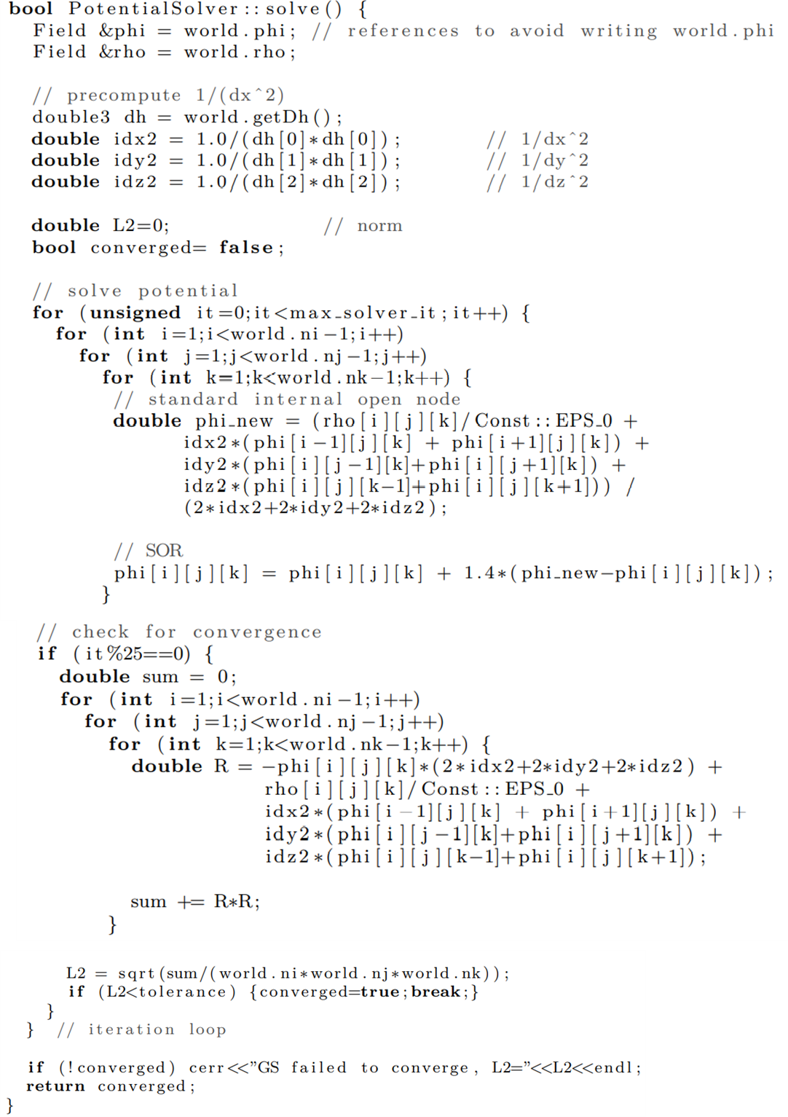

For the electric field, it's fairly simple also. Similar to equation (4), (17), (18) for the electric field (except now we are in vector form):

$$
\begin{align}
\bar{E}_{i,j,k} = \left(\frac{ \phi_{i-1,j,k}+ \phi_{i+1,j,k}}{2\Delta x} \right) \hat{i}+\left(\frac{ \phi_{i,j-1,k}+ \phi_{i,j+1,k}}{2\Delta y}\right)  \hat{j}+\left(\frac{ \phi_{i,j,k-1}+ \phi_{i,j,k+1}}{2\Delta z} \right)\hat{k}
\tag{25}
\end{align}
$$

and for the boundaries

$$
\begin{align}
(E_x)_{i=0} = \frac{ 3\phi_{0,j,k}+ 4\phi_{1,j,k} - \phi_{2,j,k}}{2\Delta x}  
\tag{26}
\end{align}
$$

$$
\begin{align}
(E_x)_{i=n-1} = \frac{ -\phi_{n-3,j,k}+ 4\phi_{n-2,j,k} - \phi_{n-1,j,k}}{2\Delta x}  
\tag{27}
\end{align}
$$

And similarly for the $y$ and $z$ directions.

Below is the pseudo code

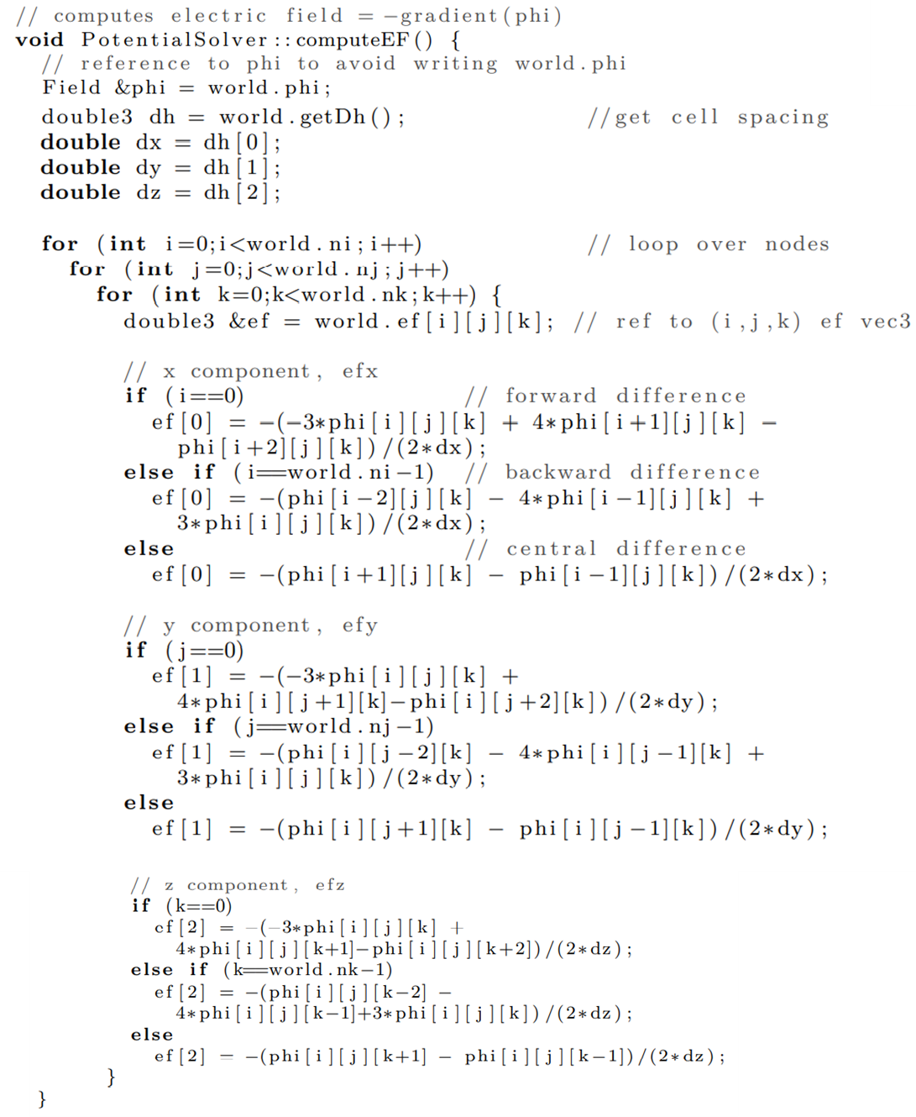